<a href="https://colab.research.google.com/github/HokusAI-Art/HokusAI-Server/blob/main/HokusAI_Worker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installation**
Setting up Pixray

https://dazhizhong.gitbook.io/pixray-docs/quickstart/installation

In [ ]:
#@title Rerolling the GPU until we get a good one

import os

model = !nvidia-smi
GPU_model = model[8]


def restart_runtime():
    os.kill(os.getpid(), 9)


if ('Tesla T4' in GPU_model) or ('Tesla P100-PCIE...' in GPU_model):
    print('Fast T4 or P100 GPU :)')
else:
    print('Bad Tesla K80 GPU :(')

Fast T4 or P100 GPU :)


In [ ]:
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left. You should only need to run this part once.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
# this patch applied to fix torchtext dependency 11 Nov 2021
!pip install torch==1.9.0+cu111 torchtext==0.10.0 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch/ -f https://download.pytorch.org/whl/torchvision/

!git clone https://github.com/openai/CLIP
# !pip install taming-transformers
!git clone https://github.com/CompVis/taming-transformers.git
!rm -Rf pixray
!git clone https://github.com/dribnet/pixray
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia==0.6.1
!pip install imageio-ffmpeg   
!pip install einops
!pip install torch-optimizer
!pip install easydict
!pip install braceexpand
!pip install git+https://github.com/pvigier/perlin-numpy
!mkdir -p steps
!mkdir -p models

import sys
sys.path.append("pixray")

In [ ]:
#@title More Dependencies

#@markdown I don't really remember which dependencies I need anymore,
#@markdown but if I remove them it breaks sooo

!pip install fastapi nest-asyncio pyngrok uvicorn aiofiles python-multipart firebase-admin

## please please please upload your firebase credentials *right now* 🥺

# **Creating the Generating Function**

In [ ]:
import torch
import pixray
from datetime import datetime

import firebase_admin
from firebase_admin import credentials, firestore, storage

if not firebase_admin._apps:
    cred = credentials.Certificate("firebaseKey.json")
    firebase_admin.initialize_app(cred, {
        'storageBucket': 'hokusai-891a9.appspot.com' # Firebase storage path without the gs://
    })

db = firestore.client()
bucket = storage.bucket()

def generate(doc_id, init_image, prompt, quality, drawer, aspect, iterations, target_image, image_prompts):
    torch.cuda.empty_cache()
    pixray.reset_settings()

    if init_image == '':
        init_image = None

    if target_image == '':
        target_image = None

    if image_prompts == '':
        image_prompts = None
        
    pixray.add_settings(prompts=prompt, init_image=init_image, aspect=aspect, quality=quality, drawer=drawer, scale=2.5)
    pixray.add_settings(iterations=iterations)
    pixray.add_settings(target_images = target_image)
    pixray.add_settings(image_prompts = image_prompts, image_prompt_weight = 1.0, image_prompt_shuffle = True)
    pixray.add_settings(display_clear=True) # Do this so you don't get overwhelmed with output
    
    settings = pixray.apply_settings()
    pixray.do_init(settings)
    pixray.do_run(settings)

    image_blob = bucket.blob(f'generated_images/{doc_id}.png')
    image_blob.upload_from_filename('output.png')
    image_blob.make_public()

    return image_blob.public_url

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.

--> Not running with fft support No module named 'aphantasia'
--> Not running with pydiffvg drawer support  No module named 'pydiffvg'


# **Worker**

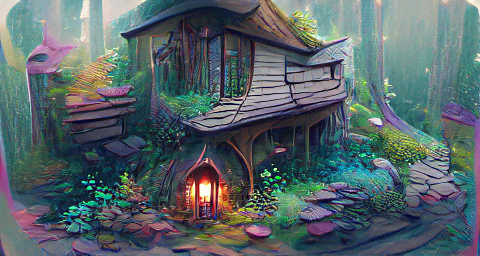

iter: 100, finished (-12=>3.229)
Generated A fantasy magical cottage in the woods | Artstation for 9jK42O8L8cSTA080A3qcwO53TO62_fcc48820-d282-4b42-877c-d0a901378146


KeyboardInterrupt: ignored

In [ ]:
import firebase_admin
from firebase_admin import credentials, storage, firestore
import time
from datetime import datetime


transaction = db.transaction()

@firestore.transactional
def claim_task(transaction, queue_objects_ref):
    # query firestore
    queue_objects = queue_objects_ref.stream(transaction=transaction)

    # pull the document from the iterable
    next_item = None
    for doc in queue_objects:
        next_item = doc

    # if queue is empty return status code of 2
    if not next_item:
        return None


    # get information from the document 
    next_item_data = next_item.to_dict()
    next_item_data['id'] = next_item.id

    # delete the document and return the information
    # transaction.delete(next_item.reference)
    next_item_data['loading'] = True
    transaction.update(next_item.reference, {
        u'loading' : True
    })

    return (next_item_data, next_item.reference)


@firestore.transactional
def set_loading(transaction, loading):
    transaction.update(next_item_reference, {u'loading' : loading})


@firestore.transactional
def set_image(transaction, image_url):
    transaction.update(next_item_reference, {u'imageUrl' : image_url})


# initialize query
queue_objects_ref = (
    db.collection("art")
    .order_by("createdAt", direction="ASCENDING")
    .where(u'loading', u'==', True)
    .limit(1)
)

transaction_attempts = 0
while True:
    try:
        # apply transaction
        task = claim_task(transaction, queue_objects_ref)
        if not task:
            continue
        
        next_item_data, next_item_reference = task
        if next_item_data['loading']:
            # generate art
            public_url = generate(next_item_data['id'], next_item_data['initImage'], next_item_data['prompt'],
                                  next_item_data['quality'], next_item_data['drawer'], next_item_data['aspect'],
                                  next_item_data['iterations'], next_item_data['targetImage'], next_item_data['imagePrompt'])
            
            set_image(transaction, public_url)
            set_loading(transaction, False)

            print(f"Generated {next_item_data['prompt']} for {next_item_data['id']}")

    except Exception as e:
        print(f"Could not apply transaction. Error: {e}")
        time.sleep(5)
        transaction_attempts += 1
        if transaction_attempts > 20:
            db.collection("errors").add({
                "exception": f"Could not apply artifaication claim transaction. Error: {e}",
                "location": "Claim artifaication",
                "time": str(datetime.now())
            })
            exit()

    time.sleep(5)